In [1]:
import numpy as np
from grid import Grid

g = Grid()
g.print()

-------------------------------
| 0,0 | 1,0 | 2,0 | 3,0 | 4,0 | 
-------------------------------
| 0,1 | 1,1 | 2,1 | 3,1 | 4,1 | 
-------------------------------
| 0,2 | 1,2 | 2,2 | 3,2 | 4,2 | 
-------------------------------
| 0,3 | 1,3 | 2,3 | 3,3 | 4,3 | 
-------------------------------
| 0,4 | 1,4 | 2,4 | 3,4 | 4,4 | 
-------------------------------


# Human Tests

In [2]:
from actors import Human

h = Human(g)
h.run()

Steps: 6
Rewards: 10
---------------------
|   |   |   |   |   | 
---------------------
|   |   |   |   |   | 
---------------------
|   |   |   |   |   | 
---------------------
|   |   |   | o |   | 
---------------------
|   |   |   |   |   | 
---------------------
(3, 3)


# AI

## Q-Learning

In [2]:
from actors import QLearning

q = QLearning(g)
q.run()

print('Steps:', q.steps)
print('Rewards:', q.totalReward)


Steps: 18283
Rewards: -427


In [3]:
for episodes in range(500):
    q.resetCount()
    q.run()

print('Episodes:', episodes)
print('Steps:', q.steps)
print('Rewards:', q.totalReward)

Episodes: 499
Steps: 6
Rewards: 10


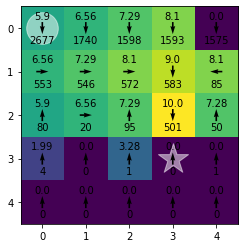

In [4]:
x = q.plot()

## Dyna-Q

In [5]:
from actors import DynaQ

d = DynaQ(g)
d.run()

print('Steps:', d.steps)
print('Rewards:', d.totalReward)

Steps: 39864
Rewards: -936


In [6]:
for episodes in range(500):
    d.resetCount()
    d.run()

print('Episodes:', episodes)
print('Steps:', d.steps)
print('Rewards:', d.totalReward)

Episodes: 499
Steps: 6
Rewards: 10


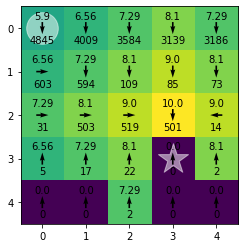

In [7]:
d.plot()

## Priority Sweping 

In [8]:
from actors import PiorSweep

p = PiorSweep(g)
p.run()

print('Steps:', p.steps)
print('Rewards:', p.totalReward)

Steps: 54
Rewards: 6


In [9]:
for episodes in range(100):
    p.resetCount()
    p.run()

print('Episodes:', episodes)
print('Steps:', p.steps)
print('Rewards:', p.totalReward)

Episodes: 99
Steps: 40
Rewards: 0


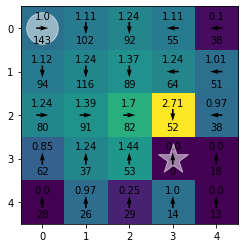

In [10]:
p.plot()